In [1]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from itertools import *
import sklearn
import math
import random
import sys
import multiprocessing
nproc = max(1, multiprocessing.cpu_count() - 1)

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

print(data_loader.load_chromosome.__doc__)
train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')
    
sess = tf.InteractiveSession()

Idempotent data loading. For a given chromosome n (a string).
    
    Returns (train_df, test_df, train_ix, test_ix, train_tissues, tfs)
    
    The first two are the train and test dataframes, and test_ix are the
    values in test_df['assayed'] that are missing and need to be imputed (with the
    correct answer being in test_df['filled'] in the corresponding locations.
    train_ix are the assayed (known) methylation values from limited microarray
    sampling (e.g., test_df['assayed'].iloc[train_ix] can be used for prediction of
    test_df['filled'].iloc[test_ix], and the former should be about equal to
    test_df['filled'].iloc[train_ix] (two different ways of sampling methylation).
    
    Imports genetic context and adds those columns to the parameter df, returning
    a merged one. tfs is the list of names of new transcription
    factors.
    
    train_tissues is a list of the names of columns with chromosome methylation values.
    
    Note that loading from scratch ma

In [2]:
# Perhaps there are obvious sequence trends?
def local_impute(data):
    #http://stackoverflow.com/questions/9537543/replace-nans-in-numpy-array-with-closest-non-nan-value
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    return data

# Do mean imputation on our training data.
def mean_impute(data):
    mask = np.isnan(data)
    data[mask] = float(data.mean()) # just = m messes with serialization
    return data
train_df_imp = train_df
train_df_int = train_df
for i in train_tissues:
    train_df_imp[i] = mean_impute(train_df[i].copy())
    train_df_int[i] = local_impute(train_df[i].copy())
print('nans in mean-imputed', np.isnan(train_df_imp[train_tissues]).sum().sum())
print('nans in interpolated', np.isnan(train_df_int[train_tissues]).sum().sum())

nans in mean-imputed 0
nans in interpolated 0


In [3]:
# Copied pretty much directly from sklearn

# Returns a TensorFlow scalar with the size of the i-th dimension for
# the parameter tensor x.
def tf_get_shape(x, i):
    return tf.squeeze(tf.slice(tf.shape(x), [i], [1])) 

def tf_nrows(x):
    return tf_get_shape(x, 0)

def tf_ncols(x):
    return tf_get_shape(x, 1)

# Simultaneous K-cluster likelihood computation.
# X is NxD, mus is KxD, sigmas is KxD
# Output is KxN likelihoods for each sample in each cluster.
def tf_log_normals(X, mus, sigmas):
    # p(X) = sqrt(a * b * c)
    # a = (2 pi)^(-p)
    # b = det(sigma)^(-1)
    # c = exp(-(x - mu)^T sigma^(-1) (x - mu)) [expanded for numerical stability]
    #
    # Below we make simplifications since sigma is diag
    
    D = tf_ncols(mus)
    XT = tf.transpose(X) # pxN
    invsig = tf.inv(sigmas)
    
    loga = -tf.cast(D, 'float64') * tf.log(tf.constant(2 * np.pi, dtype='float64')) # scalar
    logb = tf.reduce_sum(tf.log(invsig), 1, keep_dims=True) # Kx1
    logc =  \
        - tf.reduce_sum(invsig * tf.square(mus), 1, keep_dims=True) \
        + 2 * tf.matmul(invsig * mus, XT) \
        - tf.matmul(invsig, tf.square(XT)) # KxN
    return 0.5 * (loga + logb + logc)

# Stably log-sum-exps likelihood along rows.
# Reduces KxN tensor L to 1xN tensor
def tf_log_sum_exp(L):
    maxs = tf.reduce_max(L, 0, keep_dims=True) # 1xN
    return tf.log(tf.reduce_sum(tf.exp(L - maxs), 0, keep_dims=True)) + maxs

# X is NxD, mus is KxD, sigmas KxD, alphas is K
# output is log probability, KxN responsibilities
def estep(X, mus, sigmas, alphas):
    alphas = tf.expand_dims(alphas, 1) # Kx1
    log_likelihood = tf_log_normals(X, mus, sigmas) + tf.log(alphas) # KxN
    sample_log_prob = tf_log_sum_exp(log_likelihood) # 1xN
    return tf.reduce_mean(sample_log_prob), tf.exp(log_likelihood - sample_log_prob)

EPS = np.finfo(float).eps
MIN_COVAR = EPS
# X is NxD, resp is KxN (and normalized along axis 0)
# Returns maximize step means, covariance, and cluster priors,
# which have dimension KxD, KxD, and K, respectively
def mstep(X, resp):
    weights = tf.reduce_sum(resp, 1) # K
    invweights = tf.expand_dims(tf.inv(weights + 10 * EPS), 1) # Kx1
    alphas = EPS + weights / (tf.reduce_sum(weights) + 10 * EPS) # K
    weighted_cluster_sum = tf.matmul(resp, X) # KxD 
    mus = weighted_cluster_sum * invweights
    avg_X2 = tf.matmul(resp, tf.square(X)) * invweights
    avg_mu2 = tf.square(mus)
    avg_X_mu = mus * weighted_cluster_sum * invweights
    sigmas = avg_X2 - 2 * avg_X_mu + avg_mu2 + MIN_COVAR
    # (x - mu) (x-mu)^T for banded. 
    return mus, sigmas, alphas

In [4]:
# Make sure N, D are small so the numerically unstable verification code
# doesn't underflow.
N = 5
D = 10

X = np.random.normal(size=(N, D))
mu = X.mean(axis=0)
sigma = X.std(axis=0)
mus = np.array([mu, mu, mu * 2])
sigmas = np.array([sigma, sigma * 2, sigma])
K = len(sigmas)
alphas = np.random.dirichlet(np.ones(K), 1)[0]

mean_ll, resp = sess.run(estep(*(tf.constant(x) for x in (X, mus, sigmas, alphas))))
def normal_likelihoods(X, mu, sigma):
    exponent = -np.dot((X - mu[np.newaxis, :]) ** 2, 1 / sigma) / 2
    return (2 * np.pi) ** (-D / 2) * np.prod(sigma) ** (-1 / 2) * np.exp(exponent)
actual = np.array([normal_likelihoods(X, mu, sigma) for mu, sigma in zip(mus, sigmas)])
actual = sklearn.preprocessing.normalize(actual * alphas[:, np.newaxis], norm='l1', axis=0)
resp = sklearn.preprocessing.normalize(resp, norm='l1', axis=0)
print('actual likelihoods', actual)
print('log likelihoods   ', resp)
rmses = np.sqrt(sklearn.metrics.mean_squared_error(actual.T, resp.T, multioutput='raw_values'))
for i, rmse in enumerate(rmses):
    print('K={} rmse={}'.format(i, rmse))

actual likelihoods [[ 0.56004977  0.55904159  0.77913312  0.67623742  0.35557478]
 [ 0.1019229   0.29423096  0.13132855  0.28109013  0.44749144]
 [ 0.33802733  0.14672746  0.08953833  0.04267245  0.19693378]]
log likelihoods    [[ 0.56004977  0.55904159  0.77913312  0.67623742  0.35557478]
 [ 0.1019229   0.29423096  0.13132855  0.28109013  0.44749144]
 [ 0.33802733  0.14672746  0.08953833  0.04267245  0.19693378]]
K=0 rmse=1.6653345369377348e-16
K=1 rmse=1.1188630228279524e-16
K=2 rmse=1.1325499295668598e-16


In [21]:

n_samples = 10

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X = np.vstack([shifted_gaussian, stretched_gaussian])

rx = np.random.choice(range(len(X)), 2, replace=False)

EM iteration 0 log likelihood -6.57183821253
EM iteration 1 log likelihood -5.2962980488
EM iteration 2 log likelihood -3.99620712358
EM iteration 3 log likelihood -3.99620712358
EM iteration 4 log likelihood -3.99620712358
Converged in 4 iterations
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


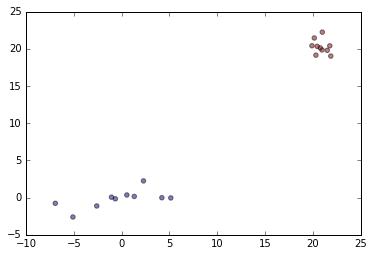

In [22]:
 _, m, s, a = fit_em(X, X[rx], 100, EPS)
_, r = estep(X, m, s, a)
r = r.eval()
r = r.argmax(axis=0)
print(r)
plt.scatter(X[:, 0], X[:, 1], c=r, alpha=0.5)
plt.show()

In [6]:
# Similar pattern to
# https://gist.github.com/narphorium/d06b7ed234287e319f18

#todo try initializing covar to emprical cv computed from kmeans labels

# Runs up to max_steps EM iterations, stopping earlier if log likelihood improves
# less than tol.
# X should be an NxD data matrix, initial_mus should be KxD
# max_steps should be an int, tol should be a float.
def fit_em(X, initial_mus, max_steps, tol):
    N, D = X.shape
    K, Dmu = initial_mus.shape
    assert D == Dmu
        
    mus0 = initial_mus
    sigmas0 = np.tile(np.var(X, axis=0), (K, 1))
    alphas0 = np.ones(K)
    X = tf.constant(X)
    
    mus, sigmas, alphas = (tf.Variable(x, dtype='float64') for x in [mus0, sigmas0, alphas0])
        
    mean_ll, resp = estep(X, mus, sigmas, alphas)
    cmus, csigmas, calphas = mstep(X, resp)
    update_mus_step = tf.assign(mus, cmus)
    update_sigmas_step = tf.assign(sigmas, csigmas)
    update_alphas_step = tf.assign(alphas, calphas)     
    
    init_op = tf.initialize_all_variables()
    ll = prev_ll = -np.inf
                         
    with tf.Session() as sess:
        sess.run(init_op)
        for i in range(max_steps):
            ll = sess.run(mean_ll)
            sess.run((update_mus_step, update_sigmas_step, update_alphas_step))
            print('EM iteration', i, 'log likelihood', ll)
            if abs(ll - prev_ll) < tol:
                break
            prev_ll = ll
        m, s, a = sess.run((mus, sigmas, alphas))
    
    print('Converged in', i, 'iterations')
        
    return ll, m, s, a

In [15]:
## GMM Stuff
np.random.seed(0)
rc = np.random.choice(range(len(train_df)), D, replace=False)

In [60]:
# Scratch work below

In [12]:
def tf_l1normalize_rows(x):
    s = tf.reduce_sum(x, 1, keep_dims=True)
    return x / s

def tf_normal(X, mu, sigma, p):
    shifted = X - mu
    sq = tf.square(shifted)
    det = tf.reduce_prod(sigma)
    sigma = tf.expand_dims(sigma, 1)
    return tf.exp(-tf.matmul(sq, tf.inv(sigma)) / 2) * tf.rsqrt(det) * (2 * np.pi) ** (-p /2)
# if it provides any comfort, tf_normal ~= tf.exp(tf_log_normal)

def tf_matrix_row(X, n, p): # X is a matrix of rows length p, gets n-th row
    return tf.squeeze(tf.slice(X, [n, 0], [1, p]))

# X is Nxp, mus is Kxp, sigmas Kxp
# output is NxK responsibilities
def responsibilities(X, mus, sigmas, alphas, K, p):
    all_norms = []
    for i in range(K):
        mu = tf_matrix_row(mus, i, p)
        sigma = tf_matrix_row(sigmas, i, p)
        all_norms.append(tf_normal_scaled(X, mu, sigma, p))
    unnorm = tf.concat(1, all_norms) # NxK unnormalized responsibility
    return tf_l1normalize_rows(unnorm * alphas)

# X is Nxp, mus is Kxp, sigmas Kxp
# output is log probability, NxK responsibilities
def estep(X, mus, sigmas, alphas, K, p):
    log_likelihood = []
    for i in range(K):
        mu = tf_matrix_row(mus, i, p)
        sigma = tf_matrix_row(sigmas, i, p)
        log_likelihood.append(tf_log_normal(X, mu, sigma, p))
    alphas = tf.expand_dims(alphas, 0) # 1xK
    log_likelihood = tf.concat(1, log_likelihood) + tf.log(alphas) # NxK likelihoods
    sample_log_prob = tf_log_sum_exp(log_likelihood)
    return tf.reduce_mean(sample_log_prob), tf.exp(log_likelihood - sample_log_prob)

EPS = np.finfo(float).eps
MIN_COVAR = 1e-3
def mstep(X, mus, sigmas, alphas, resp):
    weights = tf.reduce_sum(resp, 0)
    invweights = tf.expand_dims(tf.inv(weights + 10 * EPS), 1) # Kx1
    new_alphas = EPS + weights / (tf.reduce_sum(weights) + 10 * EPS)
    respT = tf.transpose(resp)
    weighted_cluster_sum = tf.matmul(respT, X) # Kxp 
    new_mus = weighted_cluster_sum * invweights
    avg_X2 = tf.matmul(respT, tf.square(X)) * invweights
    avg_mu2 = tf.square(mus)
    avg_X_mu = mus * weighted_cluster_sum * invweights
    new_sigma = avg_X2 - 2 * avg_X_mu + avg_mu2 + MIN_COVAR
    # (x - mu) (x-mu)^T for banded. 
    return new_alphas, new_mus, new_sigma

In [90]:
tf.exp(tf_log_normals(a, tf.pack([b, a1, b / 2, a2]), tf.pack([c, c, c / 2, c]))).eval()

array([[  4.19773441e-03,   4.19773255e-03],
       [  1.88129321e-02,   4.66325728e-05],
       [  3.92013006e-02,   3.25969829e-08],
       [  4.66326164e-05,   1.88129321e-02]], dtype=float32)

In [ ]:
N = 10
p = 20 # D is better?
K = 3
k = 0 # maximum band offset (0 is just diagonal)
tissues_to_cluster = train_tissues
X_np = train_df_imp[train_tissues].values.transpose()
X_trunc = X_np[:N, rc].astype('float32')

In [35]:
## Implement custom GMM
#todo check float32/float64 conversion for speedup
#todo scale (standardize) data before running
#todo kmeans warmup (just in numpy?)
#todo mincovar

X = tf.Variable(X_trunc, 'X') #tf.placeholder('float', shape=[N, p])

alpha0 = tf.ones([K], dtype='float') / K
alphas = tf.Variable(alpha0, 'alphas')

mu0 = X_trunc[np.random.choice(N, K, replace=False)]
mus = tf.Variable(mu0, 'mus')

# initialize the off-band with covariances
# currently just diagonal
# once random init
def tf_repeat(x, n):
    return tf.pack([x for i in range(n)]) # tf.tile instead. todo
sigma0 = tf.nn.moments(X_trunc, [0])[1]
sigmas = tf.Variable(tf_repeat(sigma0, K), 'sigmas')

# E-step
pis = responsibilities(X, mus, sigmas, alphas, K, p)

# M-step
#http://cslu.ohsu.edu/~bedricks/courses/cs655/pdf/addl_slides/pr813_lecture06.pdfttp://cslu.ohsu.edu/~bedricks/courses/cs655/pdf/addl_slides/pr813_lecture06.pdf
pisT = tf.transpose(pis)
membership = tf.reduce_sum(pisT, 1)
mu1 = tf.matmul(pisT, X) / tf.expand_dims(membership, 1)
alpha1 = membership / tf.reduce_sum(membership)

# use 

tf.set_random_seed(0)

sess.run(tf.initialize_all_variables())
print('alphas0', sess.run(alphas))
print('mus0', sess.run(mus))
print('sigmas0', sess.run(sigmas))
print('pis', sess.run(pis))
print('alphas1', sess.run(alpha1))
print('mus1', sess.run(mu1))
a, m, s = sess.run(mstep(X, mus, sigmas, alphas, pis))
print('diff alpha', sess.run(tf.reduce_sum(tf.abs(a - alpha1))))
print('diff mu', sess.run(tf.reduce_sum(tf.abs(m - mu1))))
print('sigma', s.shape, '\n', s)



alphas0 [ 0.33333334  0.33333334  0.33333334]
mus0 [[ 0.84375     0.88524592  0.43076923  0.67605633  0.22222222  0.92307693
   0.41860464  0.11111111  0.31428573  0.87037039  0.69565219  0.84507042
   0.40816328  0.86842108  0.29090908  0.25        0.86956519  0.80392158
   0.91780823  0.04938272]
 [ 0.83333331  0.875       0.42105263  0.73333335  0.17391305  0.95999998
   0.27419356  0.06382979  0.09677419  0.47499999  0.69767439  0.69230771
   0.53333336  0.77142859  0.35135135  0.16216215  0.83783782  0.8918919
   0.8888889   0.1147541 ]
 [ 0.72727275  0.953125    0.64179105  0.27710843  0.33870968  0.78181821
   0.5         0.10526316  0.69230771  0.87755102  0.3888889   0.87323946
   0.22033899  0.91666669  0.33333334  0.05660377  0.89393938  0.70175439
   0.89795917  0.9054054 ]]
sigmas0 [[ 0.02759033  0.00194256  0.01775867  0.03035834  0.01180523  0.01866075
   0.03527383  0.0640904   0.06314699  0.02359549  0.03104059  0.00453064
   0.02002618  0.03906937  0.01024649  0.00331